In [1]:
#Import the necessary libraries to perform exploratory data analysis

import pandas as pd
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
# Filepaths for database tables

#Filename path for Health Facility General Information
fn_hfinfo = r'C:\Users\Manuel Ramirez\Dropbox\Job Related Folder\Data Science Portfolio\Blog Post 2\Health_Facility_General_Information.csv'

#Filename path for Cost Transparency Excel File
fn_healtdata = r'C:\Users\Manuel Ramirez\Dropbox\Job Related Folder\Data Science Portfolio\Blog Post 2\Hospital Inpatient Cost Transparency Beginning 2009.csv'

#Filename path for NYS Zip Code and County Matches
fn_zip_region_county = r'C:\Users\Manuel Ramirez\Dropbox\Job Related Folder\Data Science Portfolio\Blog Post 2\NYS Zip Code County.csv'


# Create a dataframe that contains geographical location (county + region) and hospital tags (name + IDs) that can eventually be merged with the cost transparency dataset. 

## Work with healthcare facility database table first.

_The reason I am using the healthcare facility database table is because it matches the facility ID tags/facility names that the cost transparency database table also has. I can use them eventually as keys for a future merge. Specifically, the healthcare facility database table contains the name of the county a healthcare facility is located in. This geographical location information is not contained in the cost transparency database table._

In [3]:
#Import Health Facility General Information

#Read dataset into a dataframe
df_healthfacility = pd.read_csv(fn_hfinfo)
col2keep = df_healthfacility.columns.tolist()
col2keep = ['Facility ID',
            'Facility Name',
            'Short Description',
            'Description',
            'Facility County',
            'Main Site Name',
            'Main Site Facility ID',]
df_healthfacility = df_healthfacility.loc[:,col2keep]
df_healthfacility = df_healthfacility.rename(columns={'Facility ID':'Facility Id'})
df_healthfacility.sort_values('Facility Id').head()

,Facility Id,Facility Name,Short Description,Description,Facility County,Main Site Name,Main Site Facility ID
0,1,Albany Medical Center Hospital,HOSP,Hospital,Albany,NaN,NaN
1,2,Albany Medical Center - South Clinical Campus,HOSP,Hospital,Albany,Albany Medical Center Hospital,1.0
2,4,Albany Memorial Hospital,HOSP,Hospital,Albany,NaN,NaN
3,5,St Peters Hospital,HOSP,Hospital,Albany,NaN,NaN
4,8,Albany County Health Dept,DTC,Diagnostic and Treatment Center,Albany,NaN,NaN


_The cost transparency dataset specifically applies to Article 28 health facilities. Article 28 health facilities include hospitals, diagnostic and treatment centerThe General Health Facilities dataset includes data for article 28, 36 and 40 health facilities. Article 36 health facilities are defined as certified home health agencies, and long term home health care programs. Article 40 health facilities are defined as hospices. Therefore, health facility entries with tags CHHA, LTHHCP, and HSPC are to be ignored. See below for more details_ 

In [4]:
df_healthfacility.loc[:,['Short Description','Description']].drop_duplicates()

,Short Description,Description
0,HOSP,Hospital
4,DTC,Diagnostic and Treatment Center
9,DTC-EC,Diagnostic and Treatment Center Extension Clinic
10,NH,Residential Health Care Facility - SNF
19,NaN,Primary Care Hospital - Critical Access Hospital
89,HSPC,Hospice
153,HOSP-EC,Hospital Extension Clinic
771,CHHA,Certified Home Health Agency
912,NaN,Primary Care Hospital - Critical Access Hospit...
943,LTHHCP,Long Term Home Health Care Program


### Ignore entries for non Article 28 health facilities

In [5]:
df_hf_hosponly = df_healthfacility.copy()

#Considering all tags except LTHHCP, CHHA, HSPC
b_HOSP = (df_hf_hosponly.loc[:,'Short Description'] == 'LTHHCP') & (df_hf_hosponly.loc[:,'Short Description'] == 'CHHA') & (df_hf_hosponly.loc[:,'Short Description'] == 'HSPC')
b_HOSP = [not value for value in b_HOSP] #Flip False to True to use as a boolean mask

df_hf_hosponly = df_hf_hosponly.loc[b_HOSP,:]
df_hf_hosponly.sort_values(['Facility Name']).head(n=5)

,Facility Id,Facility Name,Short Description,Description,Facility County,Main Site Name,Main Site Facility ID
1708,6046,121st Street Family Health Center,DTC-EC,Diagnostic and Treatment Center Extension Clinic,New York,Damian Family Care Center,6067.0
2841,9205,134 Park Street Extension Clinic,HOSP-EC,Hospital Extension Clinic,Franklin,Alice Hyde Medical Center,325.0
2209,6912,14 Penn Dental Center,DTC-EC,Diagnostic and Treatment Center Extension Clinic,New York,NY Hotel Trades Council&Hotel Assoc of NYC Hea...,6911.0
3259,9704,1500 Broadway Extension Clinic,DTC-EC,Diagnostic and Treatment Center Extension Clinic,Erie,Daniel Squire Oral D & T Center,6010.0
2667,8617,2021 Grand Concourse,DTC-EC,Diagnostic and Treatment Center Extension Clinic,Bronx,Union Community Health Center,6129.0


_Notice that the hosponly dataframe contains more information that we actually need (first instance is for a DTC-EC) which we know you can't hospitalized for (otherwise it would be called a hospital). These extra entries will be eliminated when I perform a merge with the cost transparency dataset._

In [6]:
#Clean up the dataframe by getting rid of unnecessary columns. 
df_hf_hosponly = df_hf_hosponly.drop(columns=['Short Description','Description','Main Site Name','Main Site Facility ID'])
df_hf_hosponly.sort_values('Facility Name').tail(n=5)

,Facility Id,Facility Name,Facility County
1534,5536,Yonkers Gardens Adult Day Health Care Program,Westchester
574,1109,Yonkers Gardens Center for Nursing and Rehabil...,Westchester
1798,6211,Yorktown Artificial Kidney Center,Westchester
1128,3630,Yorktown Rehabilitation & Nursing Center,Westchester
3290,9739,"Your Choice at Home, Inc.",Kings


## Work with regional dataframe second.

_The general health facility dataframe only included information on the county of the health facilities. Since I want to group hospitals by their regions I needed an additional dataframe matching county to region. Unfortunately, I could not find one online. Instead I created it myself based on information online._

_New York State Regions and counties according to [Department of Environmental Conservation](https://www.dec.ny.gov/about/50230.html)_
<br>
1. __Long Island__: Nassau and Suffolk
2. __New York City__: Kings, Bronx, New York, Queens and Richmond
3. __Lower Hudson Valley__: Dutchess, Orange, Putnam, Rockland, Sullivan, Ulster and Westchester
4. __Capital Region__: Albany, Columbia, Delaware, Greene, Montgomery, Otsego, Rensselaer, Schenectady and Schoharie
5. __Eastern Adirondacks__: Clinton, Essex, Franklin, Fulton, Hamilton, Saratoga, Warren and Washington
6. __Western Adirondacks__: Herkimer, Jefferson, Lewis, Oneida and St. Lawrence
7. __Central New York__: Broome, Cayuga, Chenango, Cortland, Madison, Onondaga, Oswego, Tioga and Tompkins
8. __Western Finger Lakes__: Chemung, Genesee, Livingston, Monroe, Ontario, Orleans, Schuyler, Seneca, Steuben, Wayne and Yates
9. __Western New York__:Allegany, Chautauqua, Cattaraugus, Erie, Niagara and Wyoming
<br>

In [7]:
regions = pd.Series({'Long Island':['Nassau','Suffolk'],
           'New York City':['Kings','Bronx','New York','Queens','Richmond'],
           'Lower Hudson Valley':['Dutchess','Orange','Putnam','Rockland','Sullivan','Ulster','Westchester'], 
           'Capital Region':['Albany','Columbia','Delaware','Greene','Montgomery','Otsego','Rensselaer','Schenectady','Schoharie'], 
           'Eastern Adirondacks':['Clinton','Essex','Franklin','Fulton','Hamilton','Saratoga','Warren','Washington'],
           'Western Adirondacks':['Herkimer','Jefferson','Lewis','Oneida','Saint Lawrence'],
           'Central NY':['Broome','Cayuga','Chenango','Cortland','Madison','Onondaga','Oswego','Tioga','Tompkins'],
           'Finger Lakes':['Chemung','Genesee','Livingston','Monroe','Ontario','Orleans','Schuyler','Seneca', 'Steuben','Wayne','Yates'],
           'Western New York':['Allegany','Chautauqua','Cattaraugus','Erie','Niagara','Wyoming']})

df_region = pd.DataFrame(columns=['Geographical Region','Geographical County'])
for i in range(len(regions)):
    for counties in regions[i]:
        df_region = df_region.append({'Geographical Region':regions.index[i],'Geographical County':counties},ignore_index=True) 
df_region.head()

,Geographical Region,Geographical County
0,Long Island,Nassau
1,Long Island,Suffolk
2,New York City,Kings
3,New York City,Bronx
4,New York City,New York


## Merge all dataframes together.

In [8]:
#Merge Region with Health Facility Data Frame dataframe
df_reg_HF = df_region.merge(df_hf_hosponly,
                            how='left',
                            left_on='Geographical County',
                            right_on='Facility County')
df_reg_HF = df_reg_HF.drop(columns='Facility County')
df_reg_HF.head()

,Geographical Region,Geographical County,Facility Id,Facility Name
0,Long Island,Nassau,504,South Shore Rehabilitation and Nursing Center
1,Long Island,Nassau,490,Glen Cove Hospital
2,Long Island,Nassau,491,Glengariff Health Care Center
3,Long Island,Nassau,492,Marquis Rehabilitation & Nursing Center
4,Long Island,Nassau,493,Glen Cove Center for Nursing and Rehabilitation


In [9]:
#Merge Regional/HF with Cost Transparency Dataframe

#Import cost transparency dataframe first
df_costtransparency = pd.read_csv(fn_healtdata)
df_costtransparency.head() #Visualize Results

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
0,2016,324,Adirondack Medical Center-Saranac Lake Site,4,3,Tracheostomy W MV 96+ Hours W Extensive Proced...,Major,P,Surgical,1,161456.53,161456.53,158061.41,158061.41
1,2016,324,Adirondack Medical Center-Saranac Lake Site,5,3,Tracheostomy W MV 96+ Hours W/O Extensive Proc...,Major,P,Surgical,1,178853.06,178853.06,160794.62,160794.62
2,2016,324,Adirondack Medical Center-Saranac Lake Site,24,1,Extracranial Vascular Procedures,Minor,P,Surgical,12,15339.81,15400.58,9363.97,9451.71
3,2016,324,Adirondack Medical Center-Saranac Lake Site,24,2,Extracranial Vascular Procedures,Moderate,P,Surgical,9,19468.62,17476.12,11495.73,10141.73
4,2016,324,Adirondack Medical Center-Saranac Lake Site,24,3,Extracranial Vascular Procedures,Major,P,Surgical,4,38055.12,42715.00,25982.11,28718.38


## Obtain more information on the cost transparency dataset.

In [10]:
df_costtransparency.describe()

,Year,Facility Id,APR DRG Code,APR Severity of Illness Code,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost
count,967942.000000,967942.000000,967942.000000,967942.000000,967942.000000,9.679420e+05,9.679420e+05,9.679420e+05,9.679420e+05
mean,2012.390569,938.129314,376.994289,2.339453,20.555926,4.811893e+04,4.412296e+04,1.804342e+04,1.641473e+04
std,2.293966,647.448770,247.284033,1.037441,81.669314,7.926009e+04,7.500435e+04,3.119530e+04,2.947023e+04
min,2009.000000,1.000000,1.000000,0.000000,1.000000,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00
25%,2010.000000,511.000000,192.000000,1.000000,2.000000,1.384700e+04,1.251300e+04,5.558000e+03,4.951722e+03
50%,2012.000000,895.000000,313.000000,2.000000,5.000000,2.622300e+04,2.362200e+04,9.905215e+03,8.781115e+03
75%,2014.000000,1306.000000,560.000000,3.000000,16.000000,5.208022e+04,4.708840e+04,1.942966e+04,1.742286e+04
max,2016.000000,9431.000000,956.000000,4.000000,6938.000000,7.456979e+06,7.456979e+06,7.683086e+06,7.683086e+06


In [11]:
df_costtransparency.loc[:,'Facility Name'].nunique() #How many non repeating hospital names are there?

273

In [12]:
df_costtransparency.loc[:,'Facility Id'].nunique() #How many non repeating hospital Id tags are there?

231

_There are 273 unique hospital names. However there are 231 unique Id tags. That means that there are 42 hospital names that have either no Id tags or repeat Id tags._

In [13]:
df_costtransparency.loc[:,['Facility Name','Facility Id']].isna().sum() #Output reveals all hospitals have Id tags. 

Facility Name    0
Facility Id      0
dtype: int64

In [14]:
a = df_costtransparency.loc[:,['Facility Name','Facility Id']].drop_duplicates(keep='last').sort_values(by='Facility Name')
a[a.duplicated(subset='Facility Name',keep=False)] #Only two hospital names are repeated with two different Id tags. 
#Since I do not know which Id tag is the correct one, I will leave as is. 

,Facility Name,Facility Id
940718,St Francis Hospital,180
940720,St Francis Hospital,563
454966,UPMC Chautauqua at WCA,103
454928,UPMC Chautauqua at WCA,102


In [15]:
unique_ID = df_costtransparency.loc[:,'Facility Id'].unique()
repeat_names = []

for facilityid in unique_ID:
    b_id = df_costtransparency.loc[:,'Facility Id'] == facilityid
    if df_costtransparency.loc[b_id,'Facility Name'].drop_duplicates(keep='first').shape[0] > 1: #Repeat
        repeat_names.append(facilityid)

len(repeat_names) #There are 39 hospital names that have repeated Id tags.

39

In [16]:
df_costtransparency.loc[df_costtransparency.loc[:,'Facility Id'] == repeat_names[15],'Facility Name'].drop_duplicates()

49501            NYU Winthrop Hospital
578997    Winthrop-University Hospital
Name: Facility Name, dtype: object

_This analysis reveals that the same ID tag is used for hospitals that have variants on the same name, thus indicate the same hospital. The more trustworthy value on number of hospitals is therefore Facility Id, not Facility Name._

In [17]:
#Merge Regional/Census/NCHS/HF with Cost Transparency Dataframe
df1 = df_costtransparency.merge(df_reg_HF,
                                how='left',
                                left_on='Facility Id',
                                right_on='Facility Id')
df1 = df1.rename(columns={'Facility Name_x':'Facility Name'})
df1 = df1.drop(columns='Facility Name_y')
df1.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Geographical Region,Geographical County
0,2016,324,Adirondack Medical Center-Saranac Lake Site,4,3,Tracheostomy W MV 96+ Hours W Extensive Proced...,Major,P,Surgical,1,161456.53,161456.53,158061.41,158061.41,Eastern Adirondacks,Franklin
1,2016,324,Adirondack Medical Center-Saranac Lake Site,5,3,Tracheostomy W MV 96+ Hours W/O Extensive Proc...,Major,P,Surgical,1,178853.06,178853.06,160794.62,160794.62,Eastern Adirondacks,Franklin
2,2016,324,Adirondack Medical Center-Saranac Lake Site,24,1,Extracranial Vascular Procedures,Minor,P,Surgical,12,15339.81,15400.58,9363.97,9451.71,Eastern Adirondacks,Franklin
3,2016,324,Adirondack Medical Center-Saranac Lake Site,24,2,Extracranial Vascular Procedures,Moderate,P,Surgical,9,19468.62,17476.12,11495.73,10141.73,Eastern Adirondacks,Franklin
4,2016,324,Adirondack Medical Center-Saranac Lake Site,24,3,Extracranial Vascular Procedures,Major,P,Surgical,4,38055.12,42715.00,25982.11,28718.38,Eastern Adirondacks,Franklin


## Ensure the cost transparency dataset is as you want. Clean it if needed.

_I checked to make sure that all hospitals had their corresponding county and region information. I did this by checking to see if any NaNs were present in the merged dataframe._

In [18]:
missing_facility = df1.loc[df1.loc[:,'Geographical Region'].isna(),['Facility Id','Facility Name']].drop_duplicates()
missing_facility.shape[0]

19

In [19]:
#Which Facilities do they correspond to?
missing_facility

,Facility Id,Facility Name
13105,3376,Cohen Children's Medical Center
42925,776,Nyack Hospital
207299,5785,St James Mercy Hospital - Mercycare
215298,793,Summit Park Hospital-Rockland County Infirmary
247650,585,Eastern Niagara Hospital - Newfane Division
329632,1302,SUNY Downstate Medical Center at LICH
379821,461,Lakeside Memorial Hospital
475669,1487,Coler-Goldwater Specialty Hospital & Nursing F...
493351,3297,Institute of Rehab Medicine NYU Medical Center
501584,495,Long Beach Medical Center


_It turns out there are 19 hospitals in the merged dataframes without entires on their region, county, etc. I crossreferenced these entries to the General Health Facility dataset and determined that there were no matches because the health facility dataset was updated in 2019 while the cost transparency dataset was most recently updated in July-2018 at the time of this analysis. The time discrepency of this update led to hospitals that are included in the cost transparency dataset, but were droped and not included in the Health Facility dataset._

_Further investigation revealed that these entries were missing due to the following reasons:_
 - _Hospital closures due to natural disaster, mergers or bankrupcy led to them being dropped from the dataset_
 - _Inconsistent hospital naming lead to different facility ID tag_

_In order to complete this analysis in its most full form, I wanted to ensure all entries were included. Thus, I searched online for the zip codes of the misssing hospital and mapped them to the dataframe and redid the mergers._

**Facility Name --> Zip Code** <br>
Cohen Children's Medical Center --> 11040  <br>
Nyack Hospital --> 10960  <br>
St James Mercy Hospital - Mercycare --> 14843  <br>
Summit Park Hospital-Rockland County Infirmary --> 10970  <br>
Eastern Niagara Hospital - Newfane Division --> 14108  <br>
SUNY Downstate Medical Center at LICH --> 12487  <br>
Lakeside Memorial Hospital --> 14420  <br>
Coler-Goldwater Specialty Hospital & Nursing F... --> 10044  <br>
Institute of Rehab Medicine NYU Medical Center --> 10016  <br>
Long Beach Medical Center --> 11561  <br>
Millard Fillmore Hospital --> 14221  <br>
Peninsula Hospital Center --> 11691  <br>
Sheehan Memorial Hospital --> 14204  <br>
Orange Regional Medical Center-Middletown Campus --> 10940  <br>
Long Island Jewish Schneiders Children's Hospi... --> 11042  <br>
St Francis Hospital - St Francis Hospital Beacon Division --> 12508  <br>
SVCMC-St Vincents Manhattan --> 10011  <br>
North General Hospital --> 10035  <br>
TLC Health Network Tri-County Memorial Hospital --> 14081  <br>

In [20]:
#Follows Facility ID:Zip Code format
hfID_to_zip = {3376:11040,
               776:10960,
               5785:14843,
               793:10970,
               585:14108,
               1302:12487,
               461:14420,
               1487:10044,
               3297:10016,
               495:11561,
               215:14221,
               1632:11691,
               211:14204,
               686:10940,
               3376:11042,
               179:12508,
               1471:10011,
               2968:10035,
               74:14081}

missing_facility['ZIP Code'] = missing_facility.loc[:,'Facility Id'].map(hfID_to_zip)
missing_facility

,Facility Id,Facility Name,ZIP Code
13105,3376,Cohen Children's Medical Center,11042
42925,776,Nyack Hospital,10960
207299,5785,St James Mercy Hospital - Mercycare,14843
215298,793,Summit Park Hospital-Rockland County Infirmary,10970
247650,585,Eastern Niagara Hospital - Newfane Division,14108
329632,1302,SUNY Downstate Medical Center at LICH,12487
379821,461,Lakeside Memorial Hospital,14420
475669,1487,Coler-Goldwater Specialty Hospital & Nursing F...,10044
493351,3297,Institute of Rehab Medicine NYU Medical Center,10016
501584,495,Long Beach Medical Center,11561


_The plan is to add the facility Id's and facility names to the general healthcare dataset used and re-merge to the cost transparency dataset. But, I first need to add their geographical location information. This is what I do below.

In [21]:
#Import zip code dataframe which connects zip codes to geographical counties. Then merge with DF of missing hospitals.

#Read dataset into a dataframe
zip_to_county = pd.read_csv(fn_zip_region_county,usecols=[0,1])

#Get rid of the phrase 'Zip Code '
for i in range(zip_to_county.shape[0]):
    dummy_a = zip_to_county.loc[i,'ZIP Code']
    zip_to_county.loc[i,'ZIP Code'] = dummy_a[9:]

zip_to_county.head()

,ZIP Code,County
0,00501,Suffolk
1,00544,Suffolk
2,06390,Suffolk
3,10001,New York
4,10002,New York


In [22]:
zip_to_county = zip_to_county.astype({'ZIP Code':'int64'})
missing_facility = missing_facility.merge(zip_to_county,how='left',left_on='ZIP Code',right_on='ZIP Code')
missing_facility = missing_facility.drop(columns='ZIP Code')
missing_facility.head()

,Facility Id,Facility Name,County
0,3376,Cohen Children's Medical Center,Nassau
1,776,Nyack Hospital,Rockland
2,776,Nyack Hospital,Rockland
3,5785,St James Mercy Hospital - Mercycare,Steuben
4,793,Summit Park Hospital-Rockland County Infirmary,Rockland


In [23]:
missing_facility = missing_facility.merge(df_region,
                                          how='left',
                                          left_on='County',
                                          right_on='Geographical County')
missing_facility = missing_facility.drop(columns='County')
missing_facility.head()

,Facility Id,Facility Name,Geographical Region,Geographical County
0,3376,Cohen Children's Medical Center,Long Island,Nassau
1,776,Nyack Hospital,Lower Hudson Valley,Rockland
2,776,Nyack Hospital,Lower Hudson Valley,Rockland
3,5785,St James Mercy Hospital - Mercycare,Finger Lakes,Steuben
4,793,Summit Park Hospital-Rockland County Infirmary,Lower Hudson Valley,Rockland


In [24]:
df_reg_HF_clean = pd.concat([df_reg_HF,missing_facility],sort=False) #Combine the original general healthcare dataframe
#(df_reg_HF) with the missing information (missing_facility) using concat.
df_reg_HF_clean.head()

,Geographical Region,Geographical County,Facility Id,Facility Name
0,Long Island,Nassau,504,South Shore Rehabilitation and Nursing Center
1,Long Island,Nassau,490,Glen Cove Hospital
2,Long Island,Nassau,491,Glengariff Health Care Center
3,Long Island,Nassau,492,Marquis Rehabilitation & Nursing Center
4,Long Island,Nassau,493,Glen Cove Center for Nursing and Rehabilitation


In [25]:
#Merge Regional/Census/NCHS/HF with Cost Transparency Dataframe
df1 = df_costtransparency.merge(df_reg_HF_clean,
                                how='left',
                                left_on='Facility Id',
                                right_on='Facility Id')
df1.head()
df1 = df1.rename(columns={'Facility Name_x':'Facility Name'})
df1 = df1.drop(columns=['Facility Name_y'])
df1.sort_values('Geographical Region',ascending=True).head(n=2)

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Geographical Region,Geographical County
448462,2013,484,St. Mary's Healthcare,223,2,Other Small & Large Bowel Procedures,Moderate,P,Surgical,3,16081.16,13370.70,6608.82,5808.45,Capital Region,Montgomery
468839,2012,4,Albany Memorial Hospital,770,2,"Drug & Alcohol Abuse Or Dependence, Left Again...",Moderate,M,Medical,1,3494.98,3494.98,991.71,991.71,Capital Region,Albany


In [26]:
#How many empty spots are there now?
df1.loc[df1.loc[:,'Geographical Region'].isna(),['Facility Id','Facility Name']].drop_duplicates().shape[0]

0

# Cost Transparency dataframe is now ready to be worked with.

In [27]:
df1.head()

,Year,Facility Id,Facility Name,APR DRG Code,APR Severity of Illness Code,APR DRG Description,APR Severity of Illness Description,APR Medical Surgical Code,APR Medical Surgical Description,Discharges,Mean Charge,Median Charge,Mean Cost,Median Cost,Geographical Region,Geographical County
0,2016,324,Adirondack Medical Center-Saranac Lake Site,4,3,Tracheostomy W MV 96+ Hours W Extensive Proced...,Major,P,Surgical,1,161456.53,161456.53,158061.41,158061.41,Eastern Adirondacks,Franklin
1,2016,324,Adirondack Medical Center-Saranac Lake Site,5,3,Tracheostomy W MV 96+ Hours W/O Extensive Proc...,Major,P,Surgical,1,178853.06,178853.06,160794.62,160794.62,Eastern Adirondacks,Franklin
2,2016,324,Adirondack Medical Center-Saranac Lake Site,24,1,Extracranial Vascular Procedures,Minor,P,Surgical,12,15339.81,15400.58,9363.97,9451.71,Eastern Adirondacks,Franklin
3,2016,324,Adirondack Medical Center-Saranac Lake Site,24,2,Extracranial Vascular Procedures,Moderate,P,Surgical,9,19468.62,17476.12,11495.73,10141.73,Eastern Adirondacks,Franklin
4,2016,324,Adirondack Medical Center-Saranac Lake Site,24,3,Extracranial Vascular Procedures,Major,P,Surgical,4,38055.12,42715.00,25982.11,28718.38,Eastern Adirondacks,Franklin


In [28]:
df1.shape

(979862, 16)

In [29]:
#Save the Cost Transparency Dataset into a csv file
df1.to_csv('Cost Transparency Regions.csv')

# Results

## Isolate Medial Conditions (APR DRG Classification) Observed

In [30]:
b_year = df1.loc[:,'Year'] == 2016
df1.loc[b_year,'APR DRG Description'].nunique() #Number of APR DRG Classifications looked at.

315

In [31]:
df1.loc[b_year,'Facility Id'].nunique() #Number of hospitals looked at.

211

In [32]:
#Identify which APR DRG Conditions were seen in the 211 hospitals 
APR_list = (df1.loc[b_year,:]
            .groupby(['Facility Id','APR DRG Description'])['APR Severity of Illness Code']
            .count()
            .unstack()).notna().sum(axis=0).sort_values(ascending=False).head(n=11).index[:11].tolist()
del APR_list[0]
APR_list

['Other Pneumonia',
 'Cellulitis & Other Bacterial Skin Infections',
 'Cardiac Arrhythmia & Conduction Disorders',
 'Kidney & Urinary Tract Infections',
 'Other Musculoskeletal System & Connective Tissue Diagnoses',
 'Chronic Obstructive Pulmonary Disease',
 'Heart Failure',
 'Septicemia & Disseminated Infections',
 'Major Gastrointestinal & Peritoneal Infections',
 'Pulmonary Edema & Respiratory Failure']

In [33]:
#Identify which APR DRG Conditions had the highest patient volumes
APR_list2 = df1.loc[b_year,:].groupby('APR DRG Description')['Discharges'].sum().sort_values(ascending=False).index[:10].tolist()
APR_list2

['Neonate Birthwt >2499G, Normal Newborn Or Neonate W Other Problem',
 'Vaginal Delivery',
 'Septicemia & Disseminated Infections',
 'Cesarean Delivery',
 'Heart Failure',
 'Other Pneumonia',
 'Knee Joint Replacement',
 'Chronic Obstructive Pulmonary Disease',
 'Schizophrenia',
 'Cellulitis & Other Bacterial Skin Infections']

In [34]:
#Combine the two lists and remove duplicates.
APR_list.extend(APR_list2)
APR_list

['Other Pneumonia',
 'Cellulitis & Other Bacterial Skin Infections',
 'Cardiac Arrhythmia & Conduction Disorders',
 'Kidney & Urinary Tract Infections',
 'Other Musculoskeletal System & Connective Tissue Diagnoses',
 'Chronic Obstructive Pulmonary Disease',
 'Heart Failure',
 'Septicemia & Disseminated Infections',
 'Major Gastrointestinal & Peritoneal Infections',
 'Pulmonary Edema & Respiratory Failure',
 'Neonate Birthwt >2499G, Normal Newborn Or Neonate W Other Problem',
 'Vaginal Delivery',
 'Septicemia & Disseminated Infections',
 'Cesarean Delivery',
 'Heart Failure',
 'Other Pneumonia',
 'Knee Joint Replacement',
 'Chronic Obstructive Pulmonary Disease',
 'Schizophrenia',
 'Cellulitis & Other Bacterial Skin Infections']

In [35]:
APR_list = list(set(APR_list))
APR_list

['Neonate Birthwt >2499G, Normal Newborn Or Neonate W Other Problem',
 'Septicemia & Disseminated Infections',
 'Pulmonary Edema & Respiratory Failure',
 'Vaginal Delivery',
 'Other Pneumonia',
 'Cellulitis & Other Bacterial Skin Infections',
 'Cardiac Arrhythmia & Conduction Disorders',
 'Cesarean Delivery',
 'Knee Joint Replacement',
 'Other Musculoskeletal System & Connective Tissue Diagnoses',
 'Heart Failure',
 'Kidney & Urinary Tract Infections',
 'Schizophrenia',
 'Major Gastrointestinal & Peritoneal Infections',
 'Chronic Obstructive Pulmonary Disease']

In [36]:
#Shorten Description Names for plots
APR_renamed_dict = dict([('Vaginal Delivery','Vaginal Delivery'),
                        ('Major Gastrointestinal & Peritoneal Infections','Major GI Infect.'),
                        ('Cesarean Delivery','Cesarean Delivery'),
                        ('Other Pneumonia','Pneumonia'),
                        ('Septicemia & Disseminated Infections','Septicemia'),
                        ('Schizophrenia','Schizophrenia'),
                        ('Knee Joint Replacement','Knee Replacement'),
                        ('Cardiac Arrhythmia & Conduction Disorders','Arrhythmia & Conduction Disord.'),
                        ('Heart Failure','Heart Failure'),
                        ('Other Musculoskeletal System & Connective Tissue Diagnoses','MSK & Connnective Tissue Disord.'),
                        ('Neonate Birthwt >2499G, Normal Newborn Or Neonate W Other Problem','Newborn, Normal & Sick'),
                        ('Cellulitis & Other Bacterial Skin Infections','Cellulitis & Bact. Skin Infect.'),
                        ('Pulmonary Edema & Respiratory Failure','Edema & Resp. Failure'),
                        ('Kidney & Urinary Tract Infections','Kidney & UTI'),
                        ('Chronic Obstructive Pulmonary Disease','COPD')])

APR_list_renamed = [APR_renamed_dict[name] for name in APR_list]
APR_list_renamed

['Newborn, Normal & Sick',
 'Septicemia',
 'Edema & Resp. Failure',
 'Vaginal Delivery',
 'Pneumonia',
 'Cellulitis & Bact. Skin Infect.',
 'Arrhythmia & Conduction Disord.',
 'Cesarean Delivery',
 'Knee Replacement',
 'MSK & Connnective Tissue Disord.',
 'Heart Failure',
 'Kidney & UTI',
 'Schizophrenia',
 'Major GI Infect.',
 'COPD']

In [37]:
#Create a mask that only includes the 15 APR DRG Conditions 
bAPR_list = [df1.loc[:,'APR DRG Description'] == APR_list[i] for i in range(len(APR_list))]

for i in range(len(bAPR_list)):
    if i == 0:
        bAPR_mask = bAPR_list[0]
    else:
        bAPR_mask = bAPR_mask | bAPR_list[i]

## Create Boxplots
Now that I have identified the 15 APR DRG classifications and the regions, I can plot my results. I chose to plot using box and whisker plots. In order to plot multiple box and whisker plots in 1 subplot, they need to be ordered in a list (which I do using the function listsoflists) found below.

In [38]:
def listsoflists(df_groupby):
    """
    In order to plot a series of boxplots in the same figure the data needs to be preprocessed into a list. Each element 
    of the list is itself, a list of values.
    
    In my case, I pass a groupby object that has been grouped by either geographic region/NCHS classification and I view 
    the median/mean hospital charge or median/mean hospital cost.
    ----------------------------------------
    Inputs: Groupby object
    
    Outputs: Nested list containing a series of int values. 
    """
    list_of_list = [] #Initialize an empty list

    for name,group in df_groupby:
        list_of_list.append(group)
    return list_of_list

In [39]:
def pricek(max_price,interval):
    """
    In order to make the monetary axis of the boxplot more readable, I generate a list of values where the thousands are
    truncated off and the letter 'k' is added at the end. For example 100,000 --> 100k
    
    Assumes values are USD.
    ----------------------------------------
    Inputs:
        max_price = Highest value. Helps define the right edge of the list.
        interval = Interval to determine spacing of the plot. Defaults to 10,000 USD unless told to.
    
    Outputs: List containing strings of cost. 
    
    """
    costlist = np.arange(0,np.ceil(max_price+interval),interval).round(-3).tolist() #Round, then convert array into a list
    costlist = [str(price)[:-5] for price in costlist] #Truncate zeros
    costlist = [price+str('k') for price in costlist] #Add 'k' to the end of the number
    costlist[0] = '0' #Set the initial value to 0
    return costlist

In [40]:
def plot_mediancharges3(df,data_columnname,data_name_list,ylabel_columnname,ylabels,valuename,filenamesave,ycustomlabels):
    """
    This function will generate 3 boxplots. The median charges will be plotted.
    
    PARAMETERS
    df = DataFrame
    
    data_name_list = Data Name which is to be displayed. Set to 1 of the 15 APR DRG Descriptions or 1 of the 9 regions.
    
    ylabel_columnname = DataFrame Column Header for y labels
    ylabels = List containing y labels. This is the data that will be iterated over.
    
    valuename = DataFrame column over which groupby object will acted upon. Set to 'Median Charge'
    
    filenamesave = Title of file for figure when saved.
    """
    fig = plt.figure(figsize=(20,11))

    #Boxplot properties
    boxprops = dict(linewidth=2,color='black')
    medianprops = dict(linewidth=2.0,color='red')
    whiskerprops = dict(linewidth=2,color='black')
    capprops = dict(linewidth=2,color='black')
    
    for i in range(0,len(data_name_list)):
        
        ############################################
        #GENERATE NESTED LIST TO BE USED FOR BOXPLOT DATA

        mask = (df.loc[:,ylabel_columnname].isin(ylabels)) & (df.loc[:,'Year'] == 2016) & (df.loc[:,data_columnname] == data_name_list[i])  
        df_grouped = df.loc[mask].groupby([ylabel_columnname])[valuename]

        ylabels_sorted = list(df_grouped.groups.keys())
        data = listsoflists(df_grouped)

        ############################################
        #PLOTTING PORTION OF THE CODE
        ax = fig.add_subplot(1,len(data_name_list),i+1)

        box_y_pos = np.arange(len(ylabels_sorted))
        ax.boxplot(data,
                   positions=box_y_pos+1,
                   vert=False,
                   whis=[10,90],
                   showfliers=False,
                   medianprops=medianprops,
                   boxprops=boxprops,
                   whiskerprops=whiskerprops,
                   capprops=capprops)

        #Y-axis
        ax.set_yticks(np.arange(len(ylabels_sorted))+1)
        
        APR_list_renamed = [ycustomlabels[name] for name in ylabels_sorted]      
        ax.set_yticklabels(APR_list_renamed,fontsize=13)           

        if i > 0:
            ax.tick_params(axis='y',which='major',labelleft=False)

        #X-axis, old method
        #xmaxlim = df_grouped.describe(percentiles=[0.10,0.90]).loc[:,'90%'].max()
        #interval = 10000 #Interval for x-axis
        #costlistx = pricek(xmaxlim,interval)

        #ax.set_xlim(0,xmaxlim+5000)
        #ax.set_xticks(np.arange(0,np.ceil(xmaxlim+interval),interval))
        #ax.set_xticklabels(costlistx,fontsize=13)     
        #ax.tick_params(axis='x',which='major',direction='in',top=True,labeltop=True)
        #ax.grid(which='major',axis='x',linestyle=':',linewidth=1.5)

        #X-axis, new method
        costlistx = pricek(800000,10000)
        ax.set_xlim(0,80000)
        ax.set_xticks(np.arange(0,90000,10000))
        ax.set_xticklabels(costlistx,fontsize=13)
        ax.tick_params(axis='x',which='major',direction='in',top=True,labeltop=True)
        ax.grid(which='major',axis='x',linestyle=':',linewidth=1.5)
        
        #Figure
        ax.set_title(data_name_list[i],fontsize=15,pad=30)  
    
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(filenamesave,bbox_inches='tight',dpi=96*1.1)
    plt.show()

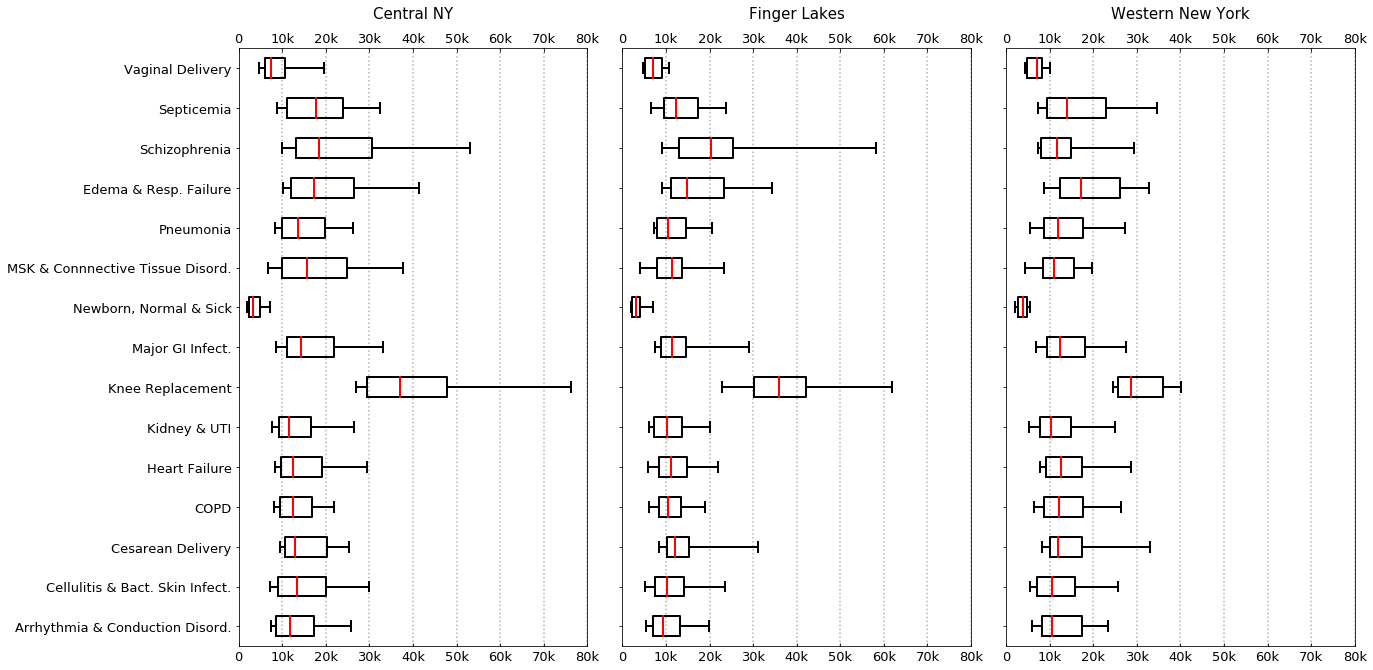

In [41]:
WesternNY = ['Central NY','Finger Lakes','Western New York'] #Select names of region for Western New York
WesternNY_fn = str('WesternNY_blog.png')
plot_mediancharges3(df1,'Geographical Region',WesternNY,'APR DRG Description',APR_list,'Median Charge',WesternNY_fn,APR_renamed_dict)

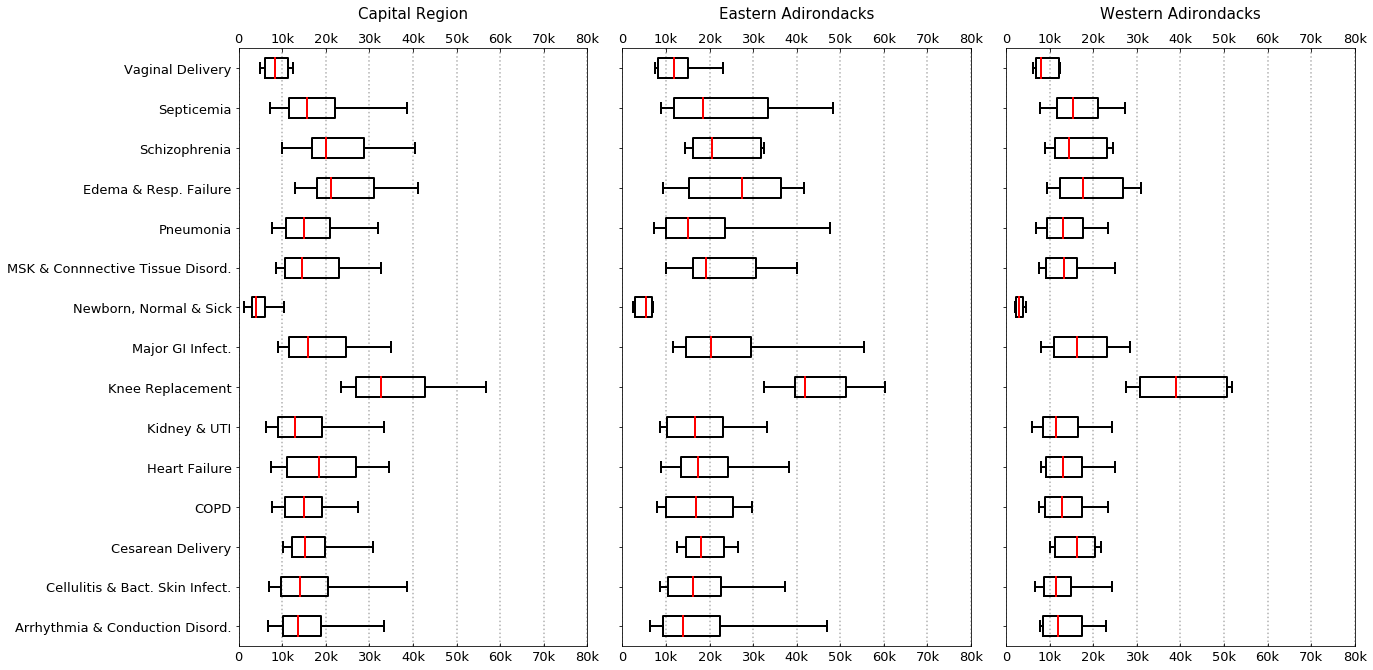

In [42]:
UpstateNY = ['Capital Region','Eastern Adirondacks','Western Adirondacks'] #Select names of region for Upstate New York
UpstateNY_fn = str('UpstateNY_blog.png')
plot_mediancharges3(df1,'Geographical Region',UpstateNY,'APR DRG Description',APR_list,'Median Charge',UpstateNY_fn,APR_renamed_dict)

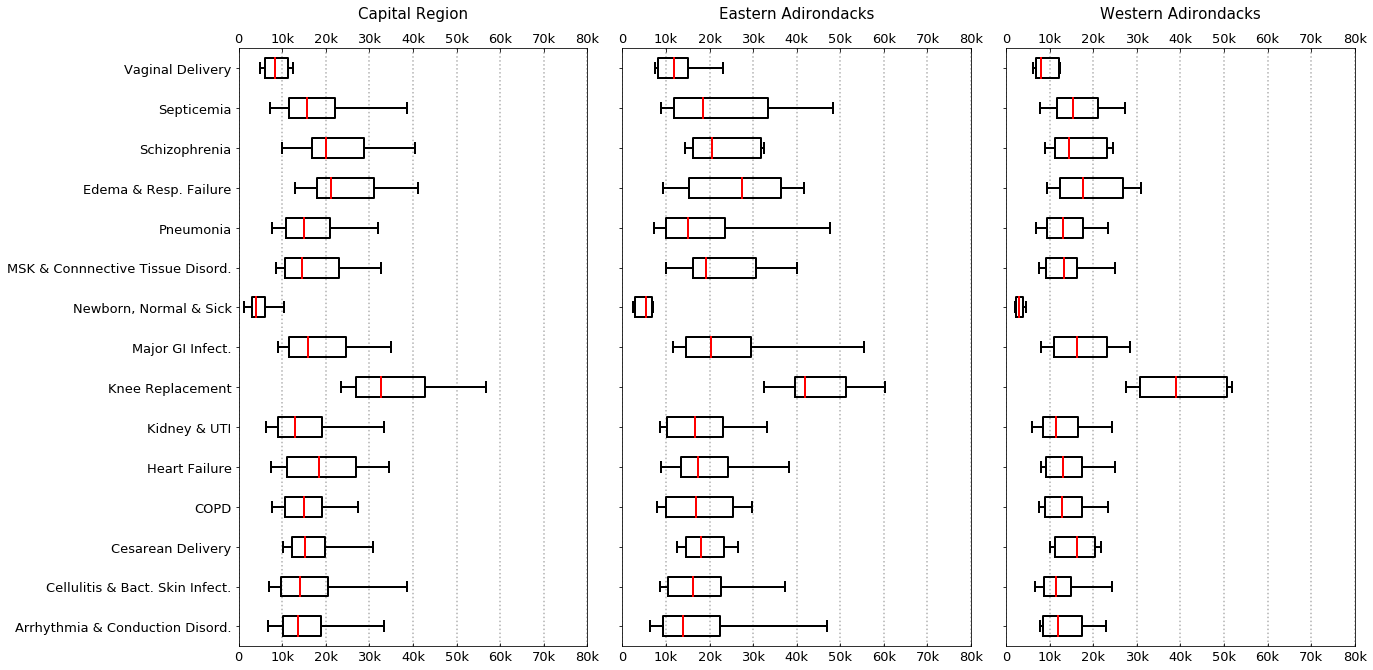

In [43]:
DownstateNY = ['Capital Region','Eastern Adirondacks','Western Adirondacks'] #Select names of region for Downstate New York
DownstateNY_fn = str('DownstateNY_blog.png')
plot_mediancharges3(df1,'Geographical Region',DownstateNY,'APR DRG Description',APR_list,'Median Charge',DownstateNY_fn,APR_renamed_dict)

## Is my hospital overcharging me?

In [44]:
#Determine mean cost for each APR DRG Condition. Since hospitals that have few discharges will sway the results, I filter out
#hospitals that didn't treat that many patients. I set my threshold to 100 discharges.
b_mindischarge = df1.loc[:,'Discharges'] > 100 #Identify APR DRG that have had a minimum 100 patients

#Find the mean charge for each of the APR DRG classifications. 
meancharge_APR = df1.loc[b_year&b_mindischarge,:].groupby('APR DRG Description')['Median Charge'].mean()
meancharge_APR.head()

APR DRG Description
Abdominal Pain                                                 22410.300000
Acute Anxiety & Delirium States                                12287.445000
Acute Myocardial Infarction                                    26480.535333
Adjustment Disorders & Neuroses Except Depressive Diagnoses     8432.038333
Alcohol & Drug Dependence W Rehab Or Rehab/Detox Therapy       25190.853750
Name: Median Charge, dtype: float64

In [45]:
#Relative Price
#Find the relative price for each hospital.
r_price = df1.loc[b_year&b_mindischarge,:].groupby(['Facility Name','APR DRG Description'])['Median Charge'].mean().unstack()

r_price = (r_price/meancharge_APR).mean(axis=1)
r_price.sort_values(ascending=False).head()

Facility Name
NYU Langone Orthopedic Hospital                          2.155993
Westchester Medical Center                               2.003768
Montefiore Mount Vernon Hospital                         1.992204
New York Presbyterian Hospital - Allen Hospital          1.965255
New York Presbyterian Hospital - Westchester Division    1.933491
dtype: float64

In [46]:
#Market share by hospital discharge volume. 
hosp_disch_marketshare = df1.loc[b_year&b_mindischarge,:].groupby('Facility Name')['Discharges'].sum()
hosp_disch_marketshare = hosp_disch_marketshare/hosp_disch_marketshare.sum()*100

In [47]:
pearR = np.corrcoef(hosp_disch_marketshare,r_price)[1,0]
pearR

0.3295686980064654

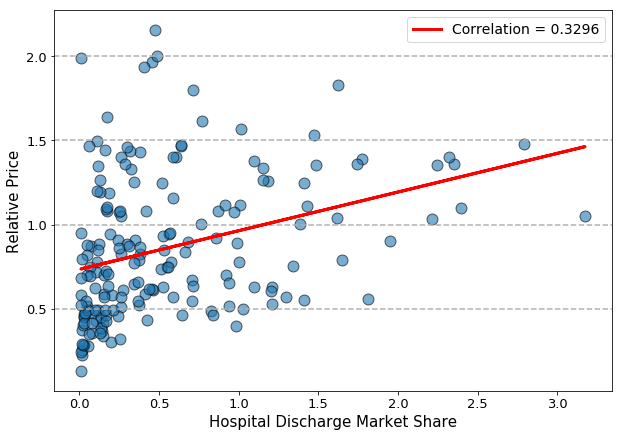

In [48]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot(1,1,1)

ax2.scatter(hosp_disch_marketshare,r_price,s=120,alpha=0.6,edgecolor='k')

ax2.set_yticks(np.arange(0,4.5,0.5))
ax2.set_yticklabels(np.arange(0,4.5,0.5),fontsize=13)
ax2.set_ylabel('Relative Price',fontsize=15)

ax2.set_xticks(np.arange(0,4.5,0.5))
ax2.set_xticklabels(np.arange(0,4.5,0.5),fontsize=13)
ax2.set_xlabel('Hospital Discharge Market Share',fontsize=15)

ax2.grid(which='major',axis='y',linestyle='--',linewidth=1.5)

A = np.vstack([hosp_disch_marketshare,np.ones(len(hosp_disch_marketshare))]).T
m,c = np.linalg.lstsq(A,r_price,rcond=None)[0]
ax2.plot(hosp_disch_marketshare,m*hosp_disch_marketshare+c,'r',linewidth=3,label=str("Correlation = {:.4f}").format(pearR))
ax2.legend(loc='upper right',fontsize=14)

plt.savefig('Relative Price vs. Market Share.png',bbox_inches='tight',dpi=96*1.1)
plt.show()

## Do certain regions hospitals overcharge?

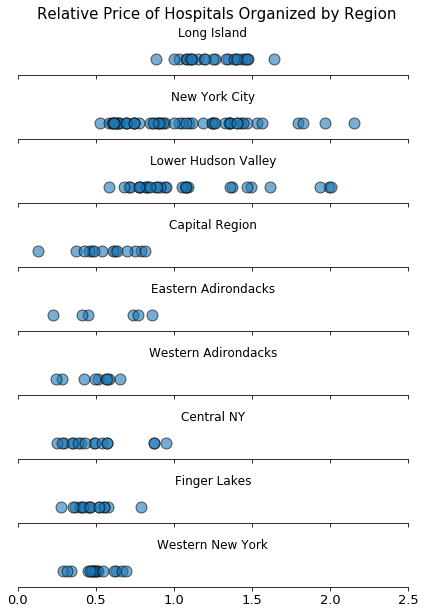

In [49]:
reg_name = regions.index.tolist()

df_rprice = pd.DataFrame(r_price)
df_rprice = df_rprice.rename(columns={0:'Relative Price'})
df_rprice = df_rprice.merge(df1.loc[b_mindischarge&b_year,['Geographical Region','Facility Name']].drop_duplicates(),how='left',on='Facility Name')

fig3 = plt.figure(figsize=(7,10),edgecolor='k')

for i in range(0,len(reg_name)):
    subplot_title = reg_name[i]
    x = df_rprice.loc[df_rprice.loc[:,'Geographical Region'] == subplot_title,'Relative Price']
    y = np.repeat(0,len(x))
    
    ax3 = fig3.add_subplot(len(reg_name),1,i+1)
    ax3.scatter(x,y,s=120,alpha=0.6,edgecolor='k')

    if i == len(reg_name)-1:
        ax3.set_xticks(np.arange(0,3,0.5))
        ax3.set_xticklabels(np.arange(0,3,0.5),fontsize=13)
        ax3.tick_params(axis='x',which='major',labelbottom=True)
    else:
        ax3.set_xticks(np.arange(0,3,0.5))
        ax3.set_xticklabels([])       
        
    ax3.tick_params(axis='y',which='major',length=0,labelsize=0,labelleft=False)
    
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    
    plt.subplots_adjust(hspace=1)
    
    ax3.set_title(reg_name[i])

fig3.suptitle('Relative Price of Hospitals Organized by Region',x=0.52,y=0.93,fontsize=15)
plt.savefig('Relative Price Geography.png',bbox_inches='tight',dpi=96*1.1)

plt.show()